# Adversarial Audio Examples

This notebook demonstrates how to use the ART library to create adversarial audio examples.

---

## Preliminaries

Before diving into the different steps necessary, we walk through some initial work steps ensuring that the notebook will work smoothly. We will 

1. set up a small configuration cell,
2. check if the test data and pretrained model are available or otherwise download them
3. define some necessary Python classes to handle the data.

**Important note:** This notebook requires `torch==1.4.0`, `torchvision==0.5.0` and `torchaudio==0.4.0`.

In [1]:
import glob
import os

import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchaudio



from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
from art import config
from art.defences.preprocessor import Mp3Compression
from art.utils import get_file

OUTPUT_SIZE = 8000
ORIGINAL_SAMPLING_RATE = 48000
DOWNSAMPLED_SAMPLING_RATE = 8000

# set global variables
AUDIO_DATA_PATH = os.path.join(config.ART_DATA_PATH, "audiomnist/test")
AUDIO_MODEL_PATH = os.path.join(config.ART_DATA_PATH, "adversarial_audio_model.pt")

# set seed
np.random.seed(123)

In [2]:
# download AudioMNIST data and pretrained model
get_file('adversarial_audio_model.pt', 'https://www.dropbox.com/s/o7nmahozshz2k3i/model_raw_audio_state_dict_202002260446.pt?dl=1')
get_file('audiomnist.tar.gz', 'https://api.github.com/repos/soerenab/AudioMNIST/tarball');

In [3]:
%%bash -s "$AUDIO_DATA_PATH" "$ART_DATA_PATH"
mkdir -p $1
tar -xf $2/audiomnist.tar.gz \
    -C $1 \
    --strip-components=2 */data \
    --exclude=**/*/{01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48}

In [4]:
# dataloader and preprocessing classes.
class AudioMNISTDataset(torch.utils.data.Dataset):
    """Dataset object for the AudioMNIST data set."""
    def __init__(self, root_dir, transform=None, verbose=False):
        self.root_dir = root_dir
        self.audio_list = sorted(glob.glob(f"{root_dir}/*/*.wav"))
        self.transform = transform
        self.verbose = verbose

    def __len__(self):
        return len(self.audio_list)

    def __getitem__(self, idx):
        audio_fn = self.audio_list[idx]
        if self.verbose:
            print(f"Loading audio file {audio_fn}")
        waveform, sample_rate = torchaudio.load_wav(audio_fn)
        if self.transform:
            waveform = self.transform(waveform)
        sample = {
            'input': waveform,
            'digit': int(os.path.basename(audio_fn).split("_")[0])
        }
        return sample


class PreprocessRaw(object):
    """Transform audio waveform of given shape."""
    def __init__(self, size_out=OUTPUT_SIZE, orig_freq=ORIGINAL_SAMPLING_RATE,
                 new_freq=DOWNSAMPLED_SAMPLING_RATE):
        self.size_out = size_out
        self.orig_freq = orig_freq
        self.new_freq = new_freq

    def __call__(self, waveform):
        transformed_waveform = _ZeroPadWaveform(self.size_out)(
            _ResampleWaveform(self.orig_freq, self.new_freq)(waveform)
        )
        return transformed_waveform


class _ResampleWaveform(object):
    """Resample signal frequency."""
    def __init__(self, orig_freq, new_freq):
        self.orig_freq = orig_freq
        self.new_freq = new_freq

    def __call__(self, waveform):
        return self._resample_waveform(waveform)

    def _resample_waveform(self, waveform):
        resampled_waveform = torchaudio.transforms.Resample(
            orig_freq=self.orig_freq,
            new_freq=self.new_freq,
        )(waveform)
        return resampled_waveform


class _ZeroPadWaveform(object):
    """Apply zero-padding to waveform.

    Return a zero-padded waveform of desired output size. The waveform is
    positioned randomly.
    """
    def __init__(self, size_out):
        self.size_out = size_out

    def __call__(self, waveform):
        return self._zero_pad_waveform(waveform)

    def _zero_pad_waveform(self, waveform):
        padding_total = self.size_out - waveform.shape[-1]
        padding_left = np.random.randint(padding_total + 1)
        padding_right = padding_total - padding_left
        padded_waveform = torch.nn.ConstantPad1d(
            (padding_left, padding_right),
            0
        )(waveform)
        return padded_waveform

In [5]:
# RawAudioCNN model class
class RawAudioCNN(nn.Module):
    """Adaption of AudioNet (arXiv:1807.03418)."""
    def __init__(self):
        super().__init__()
        # 1 x 8000
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 100, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2))
        # 32 x 4000
        self.conv2 = nn.Sequential(
            nn.Conv1d(100, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 64 x 2000
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 128 x 1000
        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 128 x 500
        self.conv5 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 128 x 250
        self.conv6 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 128 x 125
        self.conv7 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 64 x 62
        self.conv8 = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            # maybe replace pool with dropout here
            nn.MaxPool1d(2, stride=2))

        # 32 x 30
        self.fc = nn.Linear(32 * 30, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = x.view(x.shape[0], 32 * 30)
        x = self.fc(x)
        return x

In [6]:
def display_waveform(waveform, title="", sr=8000):
    """Display waveform plot and audio play UI."""
    plt.figure()
    plt.title(title)
    plt.plot(waveform)
    ipd.display(ipd.Audio(waveform, rate=sr))

## Load Model and Test Data

In the following section we are going to load the pretrained model that we downloaded in the previous section. Let's also load the test data set from which we will generate adversarial examples.

In [7]:
# load AudioMNIST test set
audiomnist_test = AudioMNISTDataset(
    root_dir=AUDIO_DATA_PATH,
    transform=PreprocessRaw(),
)

# load pretrained model
model = RawAudioCNN()
model.load_state_dict(
    torch.load(AUDIO_MODEL_PATH, map_location="cpu")
)
model.eval();

## Create Adversarial Examples

After loading the test set and model, we are ready to employ the ART library. We will first load a sample, which here will have label 1. The classification model correctly classifies it as such. We will then use ART and perform a Projected Gradient Descent attack. The attack will corrupt the spoken audio and will be misclassified as 9. However, there is almost no hearable difference in the original audio file and the adversarial audio file.

In [8]:
# wrap model in a ART classifier
classifier_art = PyTorchClassifier(
    model=model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=None,
    input_shape=[1, DOWNSAMPLED_SAMPLING_RATE],
    nb_classes=10,
    clip_values=(-2**15, 2**15 - 1)
)

In [9]:
# load a test sample
sample = audiomnist_test[3559]

waveform = sample['input']
label = sample['digit']

# craft adversarial example with PGD
epsilon = .2
pgd = ProjectedGradientDescent(classifier_art, eps=epsilon)
adv_waveform = pgd.generate(
    x=torch.unsqueeze(waveform, 0).numpy()
)

# evaluate the classifier on the adversarial example
with torch.no_grad():
    _, pred = torch.max(model(torch.unsqueeze(waveform, 0)), 1)
    _, pred_adv = torch.max(model(torch.from_numpy(adv_waveform)), 1)

# print results
print(f"Original prediction (ground truth):\t{pred.tolist()[0]} ({label})")
print(f"Adversarial prediction:\t\t\t{pred_adv.tolist()[0]}")

Original prediction (ground truth):	1 (1)
Adversarial prediction:			9


We observe that for the given test sample, the model correctly classified it as **1**. Applying PGD, we can create an adversarial example that is now classified as **9**.

Now we can qualitatively explore the result.

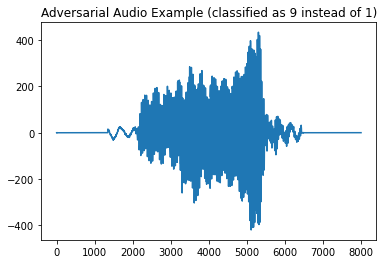

In [10]:
# display adversarial example
display_waveform(adv_waveform[0,0,:], title=f"Adversarial Audio Example (classified as {pred_adv.tolist()[0]} instead of {pred.tolist()[0]})")

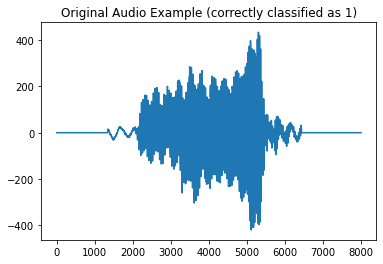

In [11]:
# display original example
display_waveform(waveform.numpy()[0,:], title=f"Original Audio Example (correctly classified as {pred.tolist()[0]})")

Let's create a second adversarial example.

In [12]:
# load a test sample
sample = audiomnist_test[3773]

waveform = sample['input']
label = sample['digit']

# craft adversarial example with PGD
epsilon = 0.5
pgd = ProjectedGradientDescent(classifier_art, eps=epsilon)
adv_waveform = pgd.generate(
    x=torch.unsqueeze(waveform, 0).numpy()
)

# evaluate the classifier on the adversarial example
with torch.no_grad():
    _, pred = torch.max(model(torch.unsqueeze(waveform, 0)), 1)
    _, pred_adv = torch.max(model(torch.from_numpy(adv_waveform)), 1)

# print results
print(f"Original prediction (ground truth):\t{pred.tolist()[0]} ({label})")
print(f"Adversarial prediction:\t\t\t{pred_adv.tolist()[0]}")

Original prediction (ground truth):	5 (5)
Adversarial prediction:			6


Now we observe that for the given test sample, the model correctly classified it as **5**. Applying PGD, we can create an adversarial example that is now classified as **6**.

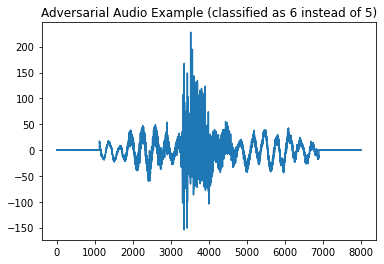

In [13]:
# display adversarial example
display_waveform(adv_waveform[0,0,:], title=f"Adversarial Audio Example (classified as {pred_adv.tolist()[0]} instead of {pred.tolist()[0]})")

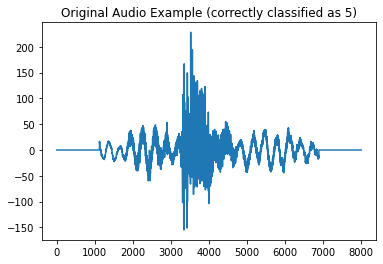

In [14]:
# display original example
display_waveform(waveform.numpy()[0,:], title=f"Original Audio Example (correctly classified as {pred.tolist()[0]})")

We present a final third example. For this example observe that the model correctly classifies it as **8**, but the adversarial example is classified as **3**.

In [15]:
# load a test sample
sample = audiomnist_test[5905]

waveform = sample['input']
label = sample['digit']

# craft adversarial example with PGD
epsilon = 0.5
pgd = ProjectedGradientDescent(classifier_art, eps=epsilon)
adv_waveform = pgd.generate(
    x=torch.unsqueeze(waveform, 0).numpy()
)

# evaluate the classifier on the adversarial example
with torch.no_grad():
    _, pred = torch.max(model(torch.unsqueeze(waveform, 0)), 1)
    _, pred_adv = torch.max(model(torch.from_numpy(adv_waveform)), 1)

# print results
print(f"Original prediction (ground truth):\t{pred.tolist()[0]} ({label})")
print(f"Adversarial prediction:\t\t\t{pred_adv.tolist()[0]}")

Original prediction (ground truth):	8 (8)
Adversarial prediction:			3


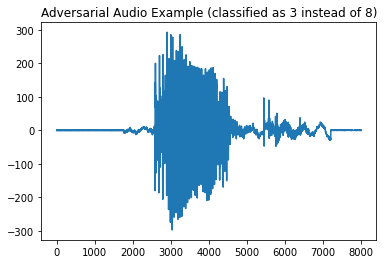

In [16]:
# display adversarial example
display_waveform(adv_waveform[0,0,:], title=f"Adversarial Audio Example (classified as {pred_adv.tolist()[0]} instead of {pred.tolist()[0]})")

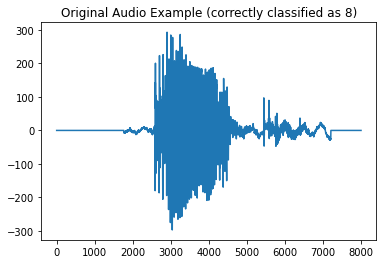

In [17]:
# display original example
display_waveform(waveform.numpy()[0,:], title=f"Original Audio Example (correctly classified as {pred.tolist()[0]})")

## Apply MP3 compression defense

Next we are going to apply a simple input preprocessing defense, namely `Mp3Compression`. Ideally, we want this defense to result in correct predictions when applied both to the original and the adversarial audio waveforms.

In [18]:
# initialize Mp3Compression defense
mp3_compression = Mp3Compression(sample_rate=DOWNSAMPLED_SAMPLING_RATE, channels_first=True)

# apply defense to original input
waveform_mp3 = mp3_compression(torch.unsqueeze(waveform, 0).numpy())[0]


# apply defense to adversarial sample
adv_waveform_mp3 = mp3_compression(adv_waveform)[0]

# evaluate the classifier on the adversarial example
with torch.no_grad():
    _, pred_mp3 = torch.max(model(torch.Tensor(waveform_mp3)), 1)
    _, pred_adv_mp3 = torch.max(model(torch.Tensor(adv_waveform_mp3)), 1)

# print results
print(f"Original prediction with MP3 compression (ground truth):\t{pred_mp3.tolist()[0]} ({label})")
print(f"Adversarial prediction with MP3 compression:\t\t\t{pred_adv_mp3.tolist()[0]}")

MP3 compression: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

Original prediction with MP3 compression (ground truth):	8 (8)
Adversarial prediction with MP3 compression:			8


## Apply adaptive whitebox attack to defeat MP3 compression defense

In [19]:
# wrap model and MP3 defense in a ART classifier
classifier_art_def = PyTorchClassifier(
    model=model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=None,
    input_shape=[1, DOWNSAMPLED_SAMPLING_RATE],
    nb_classes=10,
    clip_values=(-2**15, 2**15 - 1),
    preprocessing_defences=[mp3_compression],
)

In [20]:
# craft adversarial example with PGD
epsilon = 0.5
pgd = ProjectedGradientDescent(classifier_art_def, eps=epsilon, eps_step=0.1, max_iter=40)
adv_waveform_def = pgd.generate(
    x=torch.unsqueeze(waveform, 0).numpy()
)

pred_def = np.argmax(classifier_art_def.predict(torch.unsqueeze(waveform, 1).numpy()), axis=1)[0]
pred_adv_def = np.argmax(classifier_art_def.predict(adv_waveform_def), axis=1)[0]

# print results
print(f"Original prediction with adaptive classifier (ground truth):\t{pred_def} ({label})")
print(f"Adversarial prediction with adaptive classifier:\t\t{pred_adv_def}")

MP3 compression: 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

Original prediction with adaptive classifier (ground truth):	8 (8)
Adversarial prediction with adaptive classifier:		3


## Conclusion

In this notebook we have demonstrated how we can apply the ART library to audio data. By providing a pretrained PyTorch model and loading it via ART's `PyTorchClassifier` we can easily plug in several off the shelf attacks like Projected Gradient Descent.

Furthermore, we have demonstrated how to apply the `Mp3Compression` defense and demonstrated how to circumvent it with an adaptive whitebox attack.

---

## Reproduce CNN

Our goal is to make it as easy as possible to reproduce or modify our modified AudioMNIST classifier, which we provided as a pretrained fixture in the notebook. Therefore, we provide in the following the original code that we used for training the AudioMNIST classifier.

**Training script `train.py`**

```python
#!/usr/bin/env python

"""Train a simple AudioNet-like classifier for AudioMNIST."""

import logging
import time

import torch

from dataloader import AudioMNISTDataset, PreprocessRaw
from model import RawAudioCNN

# set global variables
AUDIO_DATA_TRAIN_ROOT = "data/audiomnist/train"
AUDIO_DATA_TEST_ROOT = "data/audiomnist/test"


def _is_cuda_available():
    return torch.cuda.is_available()


def _get_device():
    return torch.device("cuda" if _is_cuda_available() else "cpu")


def main():
    # Step 0: parse args and init logger
    logging.basicConfig(level=logging.INFO)

    generator_params = {
        'batch_size': 64,
        'shuffle': True,
        'num_workers': 6
    }

    # Step 1: load data set
    train_data = AudioMNISTDataset(
        root_dir=AUDIO_DATA_TRAIN_ROOT,
        transform=PreprocessRaw(),
    )
    test_data = AudioMNISTDataset(
        root_dir=AUDIO_DATA_TEST_ROOT,
        transform=PreprocessRaw(),
    )

    train_generator = torch.utils.data.DataLoader(
        train_data,
        **generator_params,
    )
    test_generator = torch.utils.data.DataLoader(
        test_data,
        **generator_params,
    )

    # Step 2: prepare training
    device = _get_device()
    logging.info(device)

    model = RawAudioCNN()
    if _is_cuda_available():
        model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Step 3: train
    n_epochs = 60
    for epoch in range(n_epochs):
        # training loss
        training_loss = 0.0
        # validation loss
        validation_loss = 0
        # accuracy
        correct = 0
        total = 0

        model.train()
        for batch_idx, batch_data in enumerate(train_generator):
            inputs = batch_data['input']
            labels = batch_data['digit']
            if _is_cuda_available():
                inputs = inputs.to(device)
                labels = labels.to(device)
            # Model computations
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # sum training loss
            training_loss += loss.item()
        model.eval()
        with torch.no_grad():
            for batch_idx, batch_data in enumerate(test_generator):
                inputs = batch_data['input']
                labels = batch_data['digit']
                if _is_cuda_available():
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # sum validation loss
                validation_loss += loss.item()
                # calculate validation accuracy
                predictions = torch.max(outputs.data, 1)[1]
                total += labels.size(0)
                correct += (predictions == labels).sum().item()

        # calculate final metrics
        validation_loss /= len(test_generator)
        training_loss /= len(train_generator)
        accuracy = 100 * correct / total
        logging.info(f"[{epoch+1}] train-loss: {training_loss:.3f}"
                     f"\tval-loss: {validation_loss:.3f}"
                     f"\taccuracy: {accuracy:.2f}")
    logging.info("Finished Training")

    # Step 4: save model
    torch.save(
        model,
        f"model/model_raw_audio_{time.strftime('%Y%m%d%H%M')}.pt"
    )


if __name__ == "__main__":
    main()
```

---

**Dataloader module `dataloader.py`:**

```python
import glob
import os

import numpy as np
import torch
import torchaudio


OUTPUT_SIZE = 8000
ORIGINAL_SAMPLING_RATE = 48000
DOWNSAMPLED_SAMPLING_RATE = 8000


class AudioMNISTDataset(torch.utils.data.Dataset):
    """Dataset object for the AudioMNIST data set."""
    def __init__(self, root_dir, transform=None, verbose=False):
        self.root_dir = root_dir
        self.audio_list = glob.glob(f"{root_dir}/*/*.wav")
        self.transform = transform
        self.verbose = verbose

    def __len__(self):
        return len(self.audio_list)

    def __getitem__(self, idx):
        audio_fn = self.audio_list[idx]
        if self.verbose:
            print(f"Loading audio file {audio_fn}")
        waveform, sample_rate = torchaudio.load_wav(audio_fn)
        if self.transform:
            waveform = self.transform(waveform)
        sample = {
            'input': waveform,
            'digit': int(os.path.basename(audio_fn).split("_")[0])
        }
        return sample


class PreprocessRaw(object):
    """Transform audio waveform of given shape."""
    def __init__(self, size_out=OUTPUT_SIZE, orig_freq=ORIGINAL_SAMPLING_RATE,
                 new_freq=DOWNSAMPLED_SAMPLING_RATE):
        self.size_out = size_out
        self.orig_freq = orig_freq
        self.new_freq = new_freq

    def __call__(self, waveform):
        transformed_waveform = _ZeroPadWaveform(self.size_out)(
            _ResampleWaveform(self.orig_freq, self.new_freq)(waveform)
        )
        return transformed_waveform


class _ResampleWaveform(object):
    """Resample signal frequency."""
    def __init__(self, orig_freq, new_freq):
        self.orig_freq = orig_freq
        self.new_freq = new_freq

    def __call__(self, waveform):
        return self._resample_waveform(waveform)

    def _resample_waveform(self, waveform):
        resampled_waveform = torchaudio.transforms.Resample(
            orig_freq=self.orig_freq,
            new_freq=self.new_freq,
        )(waveform)
        return resampled_waveform


class _ZeroPadWaveform(object):
    """Apply zero-padding to waveform.

    Return a zero-padded waveform of desired output size. The waveform is
    positioned randomly.
    """
    def __init__(self, size_out):
        self.size_out = size_out

    def __call__(self, waveform):
        return self._zero_pad_waveform(waveform)

    def _zero_pad_waveform(self, waveform):
        padding_total = self.size_out - waveform.shape[-1]
        padding_left = np.random.randint(padding_total + 1)
        padding_right = padding_total - padding_left
        padded_waveform = torch.nn.ConstantPad1d(
            (padding_left, padding_right),
            0
        )(waveform)
        return padded_waveform
```

---

**Model module `model.py`:**

```python
import torch.nn as nn


class RawAudioCNN(nn.Module):
    """Adaption of AudioNet (arXiv:1807.03418)."""
    def __init__(self):
        super().__init__()
        # 1 x 8000
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 100, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2))
        # 32 x 4000
        self.conv2 = nn.Sequential(
            nn.Conv1d(100, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 64 x 2000
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 128 x 1000
        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 128 x 500
        self.conv5 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 128 x 250
        self.conv6 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 128 x 125
        self.conv7 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        # 64 x 62
        self.conv8 = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            # maybe replace pool with dropout here
            nn.MaxPool1d(2, stride=2))

        # 32 x 30
        self.fc = nn.Linear(32 * 30, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = x.view(x.shape[0], 32 * 30)
        x = self.fc(x)
        return x
```

---